# Analysis of Kaggle's Titanic Dataset
Author: Daniel Pipkin

Data about the passengers aboard the Titanic has become popular in recent years. One of the reasons for this is that the data science site [Kaggle](https://kaggle.com) uses it as an introduction to machine learning<sup>[1](#Footnotes)</sup>

In [1]:
# Make plots show up in the notebook
%matplotlib inline

# Import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

# Bring an artist's touch to matplotlib's default styles
style.use('seaborn-pastel')

## Previewing Data

Before posing any questions, it is important to take a look at the data. Here are the first couple of rows.

In [19]:
# Import the titanic data
titanic_data = pd.read_csv('titanic-data.csv')

# Print first couple of rows
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Information about each column can be found [here](https://www.kaggle.com/c/titanic/data)

## Posing Questions

The two questions we are mainly focusing on:
* What factors made people more likely to survive? (Women, Children, Upper Class)
    More Women survived. What about children? More first-class passengers survived. Is there an alternative explanation.
* Was ticket price based on more than passenger class?

To answer these questions, I'm going to follow a simple loop:
1. Hypothesize an explanation for the question.
2. Gather items needed to investigate the hypothesis.
3. Investigate the relationship with one or more visualizations.
4. Draw a conclusion, then pose another hypothesis for further investigation.

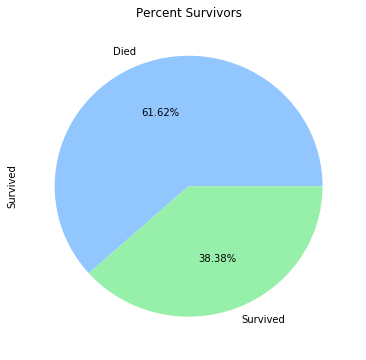

In [46]:
(titanic_data['Survived'].value_counts()                     # Count how many survived
                         .rename({0: 'Died', 1: 'Survived'}) # Rename indicies
                         .plot(kind='pie', figsize=(6, 6),
                               autopct='%.2f%%'))            # Show percents
plt.title('Percent Survivors')
plt.savefig('figures/per_survivors.png')

## "I'll never let go, Jack!"

So what factors did contribute to the survival of some passengers? The one thing I remember from Titanic is that Jack dies and Rose lives. (That, and Leonardo Decaprio toasting like [he does in every movie](http://www.vulture.com/2013/06/gif-history-of-leo-dicaprio-raising-glasses.html)). Let's use this as a starting point.  
**Hypothesis:** Women survived more than men  
Now it's time to gather the needed information.

In [ ]:
# Most of this code is going to follow a convention described
# in https://tomaugspurger.github.io/method-chaining.html

In [81]:
gender_survived_counts = (titanic_data.loc[titanic_data['Survived'] == 1, 'Sex'] # Select gender of just the survivors
                                      .value_counts())                           # Get the counts of each gender

Wow! More than twice as many women survived than men, but it's much easier to notice those types of relationships in a chart.

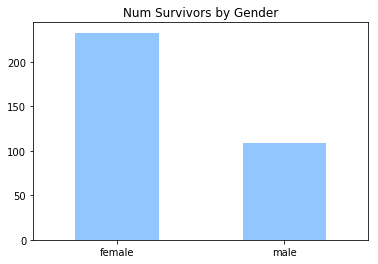

In [82]:
gender_survived_counts.plot(kind='bar', rot=0)     # Rotate the labels to make them easy to read.
plt.title('Num Survivors by Gender')
plt.savefig('figures/num_survivors_gender.png') # To track changes in version control, all charts will be saved

But this might be deceptive. Maybe there were just more women on the titanic.

In [7]:
def pipe_print(x):
    '''Prints *and* returns data
    This is useful for printing out exact numbers before charting
    '''
    print(x)
    return x

female    314
male      577
Name: Sex, dtype: int64


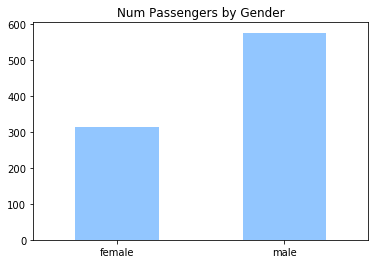

In [84]:
(titanic_data['Sex'].value_counts()  # Count *all* passengers by gender
                   .sort_index()     # Sort for consistent order of bars
                   .pipe(pipe_print) # Print the exact counts
                   .plot(kind='bar', rot=0))
plt.title('Num Passengers by Gender')
plt.savefig('figures/num_gender.png')

Normalize view so that it represents proportion of population

In [ ]:
def percent_survived(group, df=titanic_data):
    '''Returns a series of percentages of survivors
    of each `group`
    '''
    return (pd.crosstab(df[group], df['Survived'],
                        normalize=0) # Make conditional frequency table
              .loc[:, 1])            # Get percentage of just the survivors ('Survived' == 1)

Sex
female    0.742038
male      0.188908
Name: 1, dtype: float64


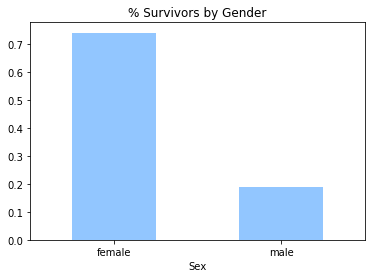

In [83]:
(percent_survived('Sex').pipe(pipe_print) # Print percent of each gender that survived
                        .plot(kind='bar', rot='0'))
plt.title('% Survivors by Gender')
plt.savefig('figures/per_survivors_gender.png')

It looks like an even higher percentage of females survived compared to males

## Women and Children First

Let's see how men, women, and children compare.

In [ ]:
def to_mwch(df):
    '''Returns whether a passenger is a child
    and if not, just returns the gender of the passenger'''
    
    # I figure once someone hits their teens,
    # they aren't a child anymore. 
    if df['Age'] < 14:
        return 'child'
    else:
        return df['Sex']

MWCh
child     0.591549
female    0.757143
male      0.162963
Name: 1, dtype: float64


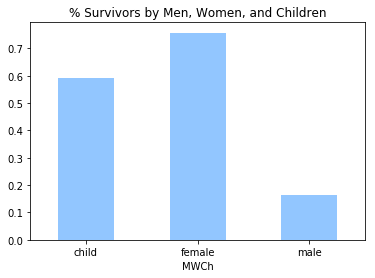

In [10]:
(titanic_data.assign(MWCh=lambda x:                   # Set a Man, Woman, Child column
                            x.apply(to_mwch, axis=1)) # using the above function
            .pipe((percent_survived, 'df'), 'MWCh')   # Get percent of survivors of each group
            .pipe(pipe_print)                         # Print exact values
            .plot(kind='bar', rot='0'))

plt.title('% Survivors by Men, Women, and Children')
plt.savefig('figures/per_survivors_mwch.png')

## Stay classy 1912
> Woman: I didn't know we had a king!  I thought we were autonomous collective.  
> Dennis: You're fooling yourself!  We're living in a dictatorship!  A self-perpetuating autocracy in which the working **classes**--  
> Woman: There you go, bringing **class** into it again...  

Women and children first, but maybe class had something to do with it too. The lower class may have some injuries and would have been helped.

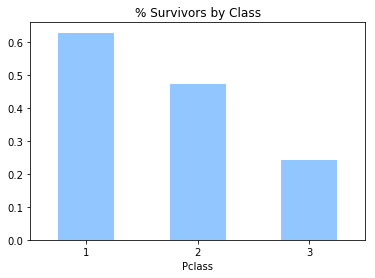

In [76]:
percent_survived('Pclass').plot(kind='bar', rot=0) # Plot the percent survivors for each Class
plt.title('% Survivors by Class')
plt.savefig('figures/per_survivors_class.png')

The lower class passengers just had a harder time getting to the deck<sup>[2](#Footnotes)</sup>

## Deck
Maybe their deck had something to do with it.

In [12]:
def to_deck(cabin):
    '''Return the deck letter of
    a given cabin. It is just the first letter
    of the cabin number'''
    
    if pd.isnull(cabin):
        return 'No Info'
    else:
        return cabin[0]

Deck
A          0.466667
B          0.744681
C          0.593220
D          0.757576
E          0.750000
F          0.615385
G          0.500000
T          0.000000
No Info    0.299854
Name: 1, dtype: float64


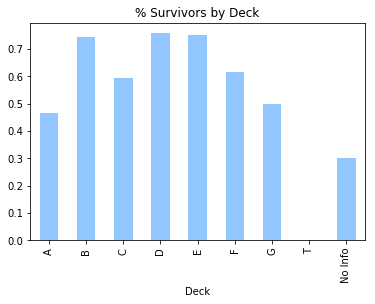

In [85]:
(titanic_data.assign(Deck=lambda x:                  # Set the deck column
                    x['Cabin'].apply(to_deck))       # using the function above
            .pipe((percent_survived, 'df'), 'Deck')  # Get percent of survivors of each deck
            .reindex(list('ABCDEFGT') + ['No Info']) # Sort so 'No Info' shows last
            .pipe(pipe_print)                        # Print exact values for each percentage
            .plot(kind='bar'))
plt.title('% Survivors by Deck')
plt.savefig('figures/per_survivors_deck.png')

As expected, lower number of survivors in the 'No Info' group. If they had survived, there would be more info. What about people on deck T?

In [75]:
titanic_data[titanic_data['Cabin'] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S


He was the passenger staying on the boat deck<sup>[3](#Footnotes)</sup>, which might be why he was last seen in the smoking room talking to the Captain<sup>[4](#Footnotes)</sup>.

## The Price is Right

I was wondering if some people had to pay different prices for different classes.

In [61]:
fares = titanic_data['Fare']
fares.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

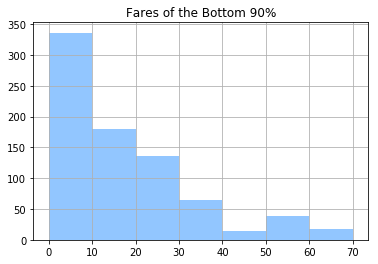

In [86]:
ninetieth = fares.quantile(0.90)   # Get the value of the 90th percentile
bins = np.arange(0, ninetieth, 10) # Create equal sized bins up to the 90th percentile

(titanic_data.loc[titanic_data['Fare'] < ninetieth, 'Fare'] # Only get fares up to 90th percentile
             .hist(bins=bins))
plt.title('Fares of the Bottom 90%')
plt.savefig('figures/fares_bottom_90.png')

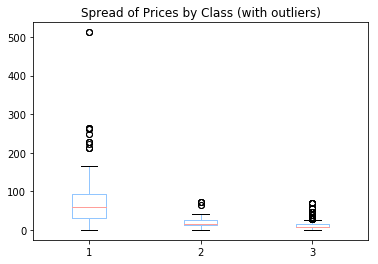

In [15]:
(titanic_data.pivot(columns='Pclass', values='Fare') # Reshape to make Pclass Series of fares
             .plot(kind='box'))
plt.title('Spread of Prices by Class (with outliers)')
plt.savefig('figures/class_price_spread_w_outliers.png')

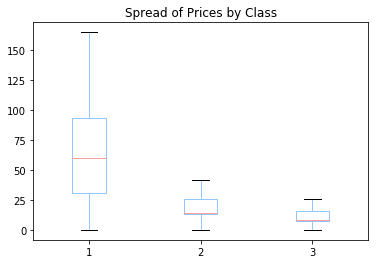

In [87]:
(titanic_data.pivot(columns='Pclass', values='Fare')
             .plot(kind='box', showfliers=False)) # Remove outliers
plt.title('Spread of Prices by Class')
plt.savefig('figures/class_price_spread.png')

Maybe something to do with the deck they are on?

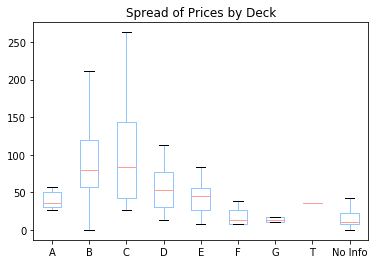

In [90]:
(titanic_data.assign(Deck=lambda x:              # Add deck column
                    x['Cabin'].apply(to_deck))   # using function from above
            .pivot(columns='Deck', values='Fare')
            [list('ABCDEFGT') + ['No Info']]     # Sort so No Info shows last
            .plot(kind='box', showfliers=False)) # Remove outliers
plt.title('Spread of Prices by Deck')
plt.savefig('figures/deck_price_spread.png')

How about ports because I want to mix things up with a line graph

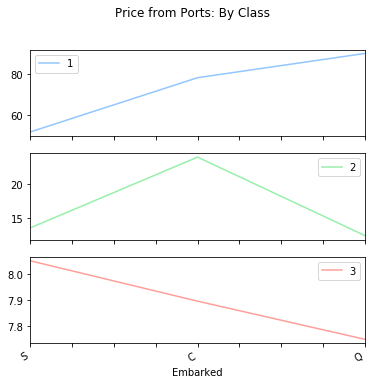

In [91]:
(titanic_data.groupby(['Embarked', 'Pclass']) # We'll want to split the fares up by class as well as embarked
            ['Fare'].median()                 # Get the median for each port of embarkation for each class
            .unstack(level=1)                 # Unstack class to columns
            .reindex(list('SCQ'))             # Rein
            .plot(subplots=True, figsize=(6, 6)))
plt.gcf().suptitle('Price from Ports: By Class')
plt.gcf().savefig('figures/price_from_ports.png')

# Footnotes
1. https://www.kaggle.com/c/titanic
> If you're new to data science and machine learning, or looking for a simple intro to the Kaggle competitions platform, this is the best place to start.
1. http://www.bbc.com/news/magazine-17515305
> Evidence given at the inquiry did suggest that initially some of the gates blocked the way of steerage passengers as stewards waited for instructions and that they were then opened, but only after most of the lifeboats had launched(...)  
> None of the evidence presented pointed to any malicious intent to obstruct third class passengers - but rather an oversight caused by unthinking obedience to the regulations, but the results were still deadly.  
1. https://www.kaggle.com/c/titanic/data  

```
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.
```
1. https://www.encyclopedia-titanica.org/titanic-victim/stephen-weart-blackwell.html
1. https://www.encyclopedia-titanica.org/cabins.html